In [48]:
import sys
sys.executable

'/opt/homebrew/opt/python@3.11/bin/python3.11'

In [49]:
import pandas as pd 
df = pd.read_excel("online_retail.xlsx")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [51]:
# 1. Drop rows without Customer ID
df = df.dropna(subset=["Customer ID"])

# 2. Remove negative quantities (returns)
df = df[df["Quantity"] > 0]

# 3. Remove zero or negative price
df = df[df["Price"] > 0]

# 4. Create TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["Price"]

# 5. Convert Customer ID to integer
df["Customer ID"] = df["Customer ID"].astype(int)

# 6. Convert InvoiceDate to datetime if needed
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407664 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407664 non-null  object        
 1   StockCode    407664 non-null  object        
 2   Description  407664 non-null  object        
 3   Quantity     407664 non-null  int64         
 4   InvoiceDate  407664 non-null  datetime64[ns]
 5   Price        407664 non-null  float64       
 6   Customer ID  407664 non-null  int64         
 7   Country      407664 non-null  object        
 8   TotalPrice   407664 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.1+ MB


In [52]:
import datetime as dt

current_date = df["InvoiceDate"].max() + dt.timedelta(days=1)
current_date


Timestamp('2010-12-10 20:01:00')

In [53]:
recency = df.groupby("Customer ID")["InvoiceDate"].max()
recency = (current_date - recency).dt.days


In [54]:
frequency = df.groupby("Customer ID")["Invoice"].nunique()
monetary = df.groupby("Customer ID")["TotalPrice"].sum()

In [55]:
rfm = pd.DataFrame({
    "Recency": recency,
    "Frequency": frequency,
    "Monetary": monetary
})

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,165,11,372.86
12347,3,2,1323.32
12348,74,1,222.16
12349,43,3,2671.14
12351,11,1,300.93


In [56]:
from sklearn.preprocessing import StandardScaler

In [57]:
scaler = StandardScaler()

In [58]:
rfm_scaled = scaler.fit_transform(rfm)

In [59]:
import pandas as pd

rfm_scaled = pd.DataFrame(
    rfm_scaled, 
    index=rfm.index,
    columns=["Recency", "Frequency", "Monetary"]
)

rfm_scaled.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,0.762299,0.801087,-0.187961
12347,-0.910402,-0.300603,-0.081329
12348,-0.177305,-0.423013,-0.204868
12349,-0.497389,-0.178193,0.069883
12351,-0.827799,-0.423013,-0.196031


In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

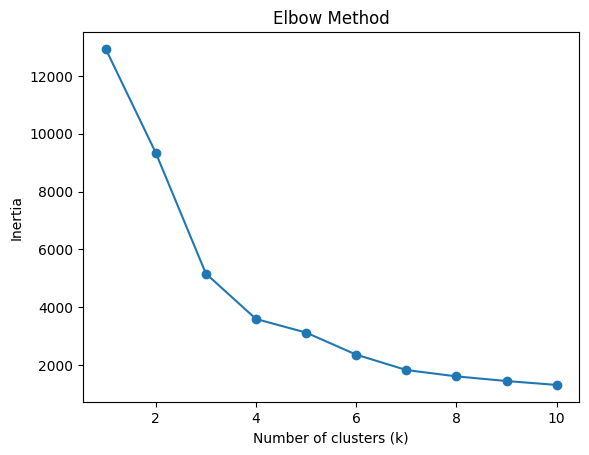

In [61]:
inertia = []

# Try different cluster counts (1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [62]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)


,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [63]:
rfm["Cluster"] = kmeans.labels_
rfm["Cluster"].value_counts()

Cluster
0    3207
1    1047
3      53
2       5
Name: count, dtype: int64

In [64]:
rfm.groupby("Cluster").mean()

,Recency,Frequency,Monetary
Cluster,,,
0,42.996882,4.469598,1743.129790
1,242.976122,1.659981,596.884493
2,5.600000,113.600000,215543.670000
3,15.433962,48.547170,29040.181566


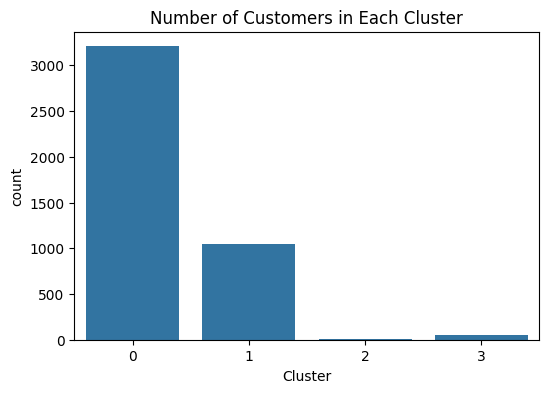

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=rfm["Cluster"])
plt.title("Number of Customers in Each Cluster")
plt.show()


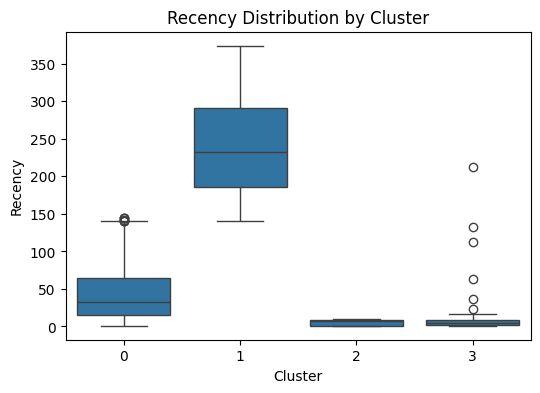

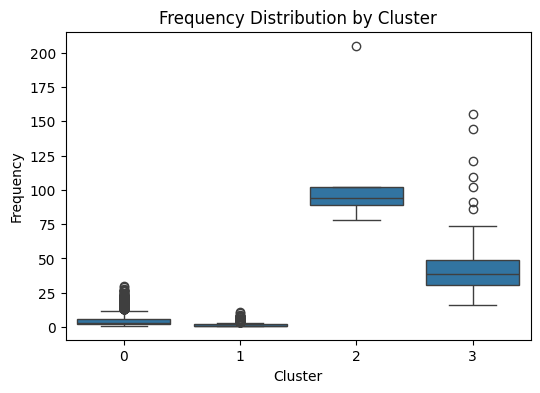

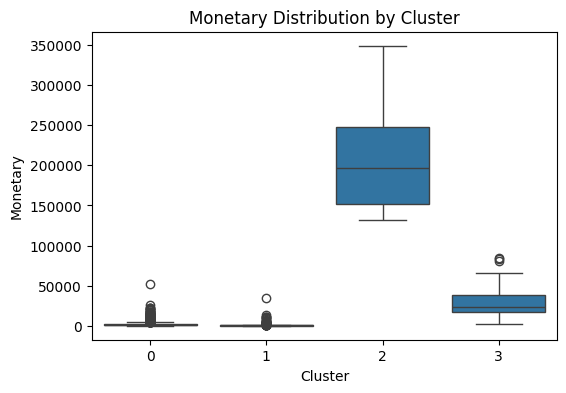

In [66]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Cluster", y="Recency", data=rfm)
plt.title("Recency Distribution by Cluster")
plt.show()
plt.figure(figsize=(6,4))
sns.boxplot(x="Cluster", y="Frequency", data=rfm)
plt.title("Frequency Distribution by Cluster")
plt.show()
plt.figure(figsize=(6,4))
sns.boxplot(x="Cluster", y="Monetary", data=rfm)
plt.title("Monetary Distribution by Cluster")
plt.show()


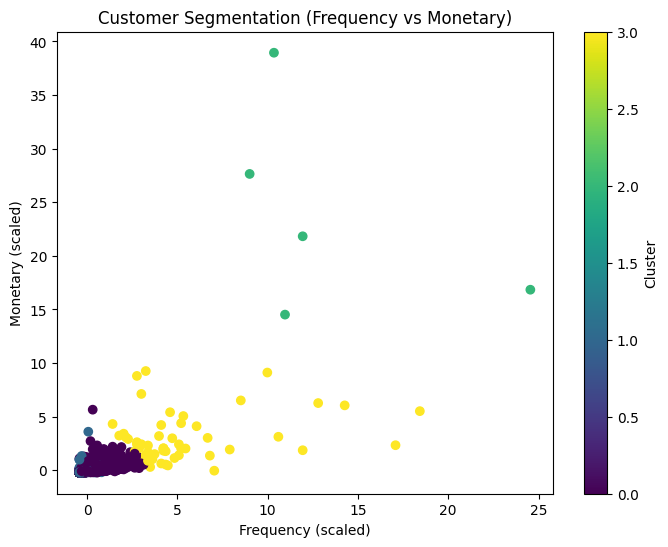

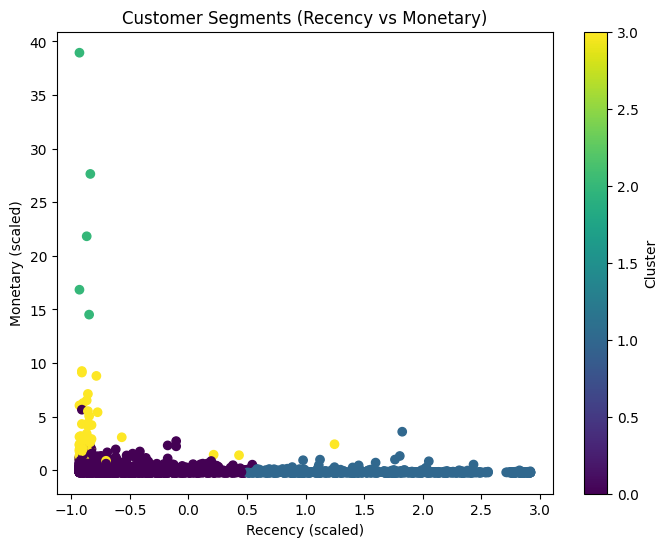

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(rfm_scaled["Frequency"], rfm_scaled["Monetary"],
            c=rfm["Cluster"], cmap="viridis")
plt.xlabel("Frequency (scaled)")
plt.ylabel("Monetary (scaled)")
plt.title("Customer Segmentation (Frequency vs Monetary)")
plt.colorbar(label="Cluster")
plt.show()
plt.figure(figsize=(8,6))
plt.scatter(rfm_scaled["Recency"], rfm_scaled["Monetary"], 
            c=rfm["Cluster"], cmap="viridis")
plt.xlabel("Recency (scaled)")
plt.ylabel("Monetary (scaled)")
plt.title("Customer Segments (Recency vs Monetary)")
plt.colorbar(label="Cluster")
plt.show()


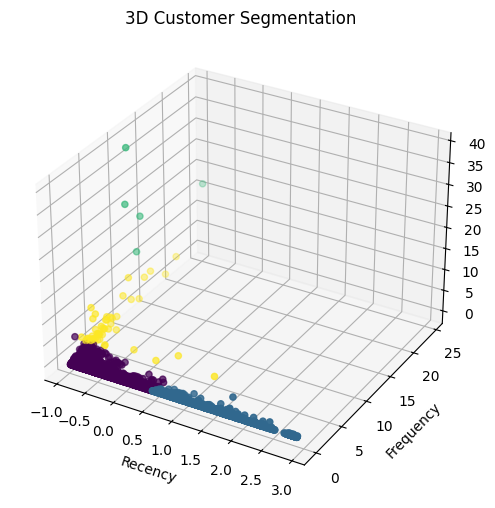

In [68]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_scaled["Recency"], rfm_scaled["Frequency"], rfm_scaled["Monetary"],
           c=rfm["Cluster"], cmap="viridis")

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.title("3D Customer Segmentation")
plt.show()


In [69]:
rfm.to_excel("customer_segments.xlsx")
